## Agenda

The idea of this project is to create a model that, given an image of a Red Blood Cell, will be able to predict whether it is infected with Malaria or not!

We would be using a lot of custom images containing infected and uninfected images of RBC's and using that, we are going to predict whether an unseen image contains the infection or not.


## The Data

The images have been organized within the `DATA` directory containing separate folders for 'Train' & 'Test' with each containing further sub-folders with desired labels -- Infected & Uninfected

And a total of 27,558 images.

**ORIGINAL DATA SOURCE:**

Acknowledgements:
This Dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/ 

### 1. Necessary imports

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sb

import tensorflow as tf
from tensorflow.compat.v1 import InteractiveSession
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)

import matplotlib.pyplot as plt
import matplotlib.image as img

%matplotlib inline

2022-03-02 02:12:22.973113: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-03-02 02:12:23.000763: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2699905000 Hz
2022-03-02 02:12:23.001293: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1b04000b60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-03-02 02:12:23.001330: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-03-02 02:12:23.004785: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-03-02 02:12:23.070785: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 02:12:23.071232:

### 2. Prepare and visualize the data

**The cell images have been extracted and kept within the `./DATA/cell_images/` folder.**

In [2]:
data_dir = './DATA/cell_images/'

In [3]:
os.listdir(data_dir)

['train', 'test']

In [4]:
train_dir = data_dir + 'train/'
test_dir = data_dir + 'test/'

os.listdir(train_dir), os.listdir(test_dir)

(['infected', 'uninfected'], ['infected', 'uninfected'])

**Checkout a single image from the Train set:**

In [5]:
image1 = os.listdir(train_dir + 'infected/')[0]
image1

'C156P117ThinF_IMG_20151115_154313_cell_271.png'

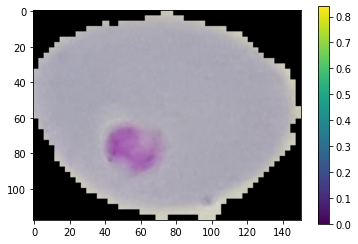

In [6]:
plt.imshow(img.imread(train_dir + 'infected/' + image1))
plt.colorbar()

**Image from the Test set:**

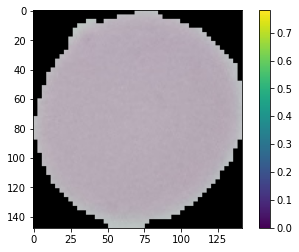

In [7]:
plt.imshow(img.imread(test_dir + 'uninfected/' + os.listdir(test_dir + 'uninfected/')[0]))
plt.colorbar()

**Check the avg dimensions of the images such that its easier to map the images to a fixed shape for modelling:**

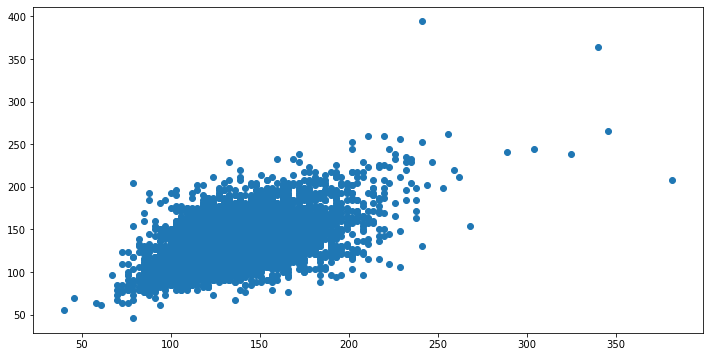

In [8]:
dim1, dim2 = [],[]

for i in os.listdir(train_dir + 'infected/'):
    image = img.imread(train_dir + 'infected/' + i)
    d1, d2, color = image.shape
    dim1.append(d1)
    dim2.append(d2)
    
plt.figure(figsize = (12, 6))
plt.scatter(dim1, dim2)

As seen above, we can see bulk of the points to be centered around the 100 - 170 mark on both axes, so checking the exact mean dimensions:

In [9]:
np.mean(dim1), np.mean(dim2), color

(134.360205144643, 133.66447632021797, 3)

As seen mean for both dimensions is around the 130 mark; therefore, it would be good to reshape the images to (130 x 130 x 3)

In [10]:
image_shape = (130, 130, 3)

### 3. Image data generation and manipulation

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
image_gen = ImageDataGenerator(rotation_range = 20,
                               width_shift_range = 0.2,
                               height_shift_range = 0.2,
                               shear_range = 0.2,
                               zoom_range = 0.3,
                               horizontal_flip = True,
                               vertical_flip = True,
                               rescale = 1 / 255,
                               fill_mode = 'nearest')

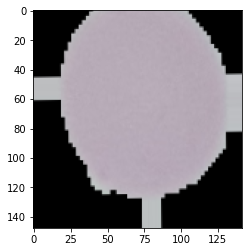

In [13]:
plt.imshow(image_gen.random_transform(img.imread(test_dir + 'uninfected/' + os.listdir(test_dir + 'uninfected/')[0])))

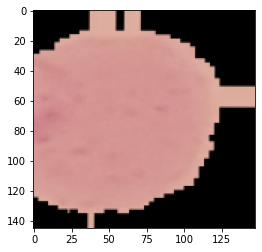

In [14]:
plt.imshow(image_gen.random_transform(img.imread(test_dir + 'infected/' + os.listdir(test_dir + 'infected/')[0])))

As seen in the images above, Image Data Generator is correctly applying the augmentation techniques as defined earlier....

**We will now generate the Training & Testing image data to feed into our CNN model:**

In [15]:
train_data_gen = image_gen.flow_from_directory(train_dir,
                                               target_size = image_shape[:2],
                                               batch_size = 64,
                                               color_mode = 'rgb',
                                               class_mode = 'binary',
                                               shuffle = True)

Found 24958 images belonging to 2 classes.


In [16]:
test_data_gen = image_gen.flow_from_directory(test_dir,
                                              target_size = image_shape[:2],
                                              batch_size = 64,
                                              color_mode = 'rgb',
                                              class_mode = 'binary',
                                              shuffle = False)

Found 2600 images belonging to 2 classes.


In [17]:
train_data_gen.class_indices, test_data_gen.class_indices

({'infected': 0, 'uninfected': 1}, {'infected': 0, 'uninfected': 1})

### 4. Create & Train the model

In [18]:
tf.keras.backend.clear_session()

img_model = tf.keras.models.Sequential([
                tf.keras.layers.Conv2D(filters = 32, kernel_size = (2, 2), strides = (1, 1), padding = 'same',
                                       activation = 'relu', input_shape = image_shape),
                tf.keras.layers.MaxPool2D(pool_size = (2, 2), strides = (1, 1)),
    
                tf.keras.layers.Conv2D(filters = 64, kernel_size = (2, 2), strides = (1, 1), padding = 'same',
                                       dilation_rate = (2, 2), activation = 'relu'),
                tf.keras.layers.MaxPool2D(pool_size = (2, 2), strides = (1, 1)),
    
    
                tf.keras.layers.Flatten(),
    
    
                tf.keras.layers.Dense(64, activation = 'relu'),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(32, activation = 'relu'),
                tf.keras.layers.Dropout(0.5),
    
                tf.keras.layers.Dense(1, activation = 'sigmoid')
])


img_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

2022-03-02 02:20:38.075756: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 02:20:38.076098: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce 940MX computeCapability: 5.0
coreClock: 1.189GHz coreCount: 3 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 29.80GiB/s
2022-03-02 02:20:38.076208: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-03-02 02:20:38.076244: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-03-02 02:20:38.076260: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-03-02 02:20:38.076276: I tensorflow/stream_executor/platfo

In [19]:
img_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 130, 130, 32)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 129, 129, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 129, 129, 64)      8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 1048576)           0         
_________________________________________________________________
dense (Dense)                (None, 64)                67108928  
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

**Train the model:**

In [20]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 10)

history = img_model.fit_generator(train_data_gen, epochs = 40, validation_data = test_data_gen, 
                                  callbacks = [early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/40


2022-03-02 02:23:45.051593: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-03-02 02:23:46.202407: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-03-02 02:23:51.203729: W tensorflow/core/common_runtime/bfc_allocator.cc:245] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.10MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-03-02 02:23:51.358978: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2022-03-02 02:23:51.396066: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-03-02 02:

ResourceExhaustedError:  OOM when allocating tensor with shape[256,66,66,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential/conv2d_1/SpaceToBatchND (defined at tmp/ipykernel_55378/1143812870.py:3) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_1074]

Function call stack:
train_function
